## Wisconsin Diagnostic Breast Cancer (WDBC) Dataset with Decision Tree Classifier

I am writing the explorative analysis of the dataset using a series of Python (ver.2.7.11) packages that facilitate the access to the data as well as the statistical analysis. In particular, I am using Panda (ver.0.17), scikit-learn (ver.0.17) together with the more common numerical packages available for Python such as numpy and matplotlib. I am also using jupyter notebooks for this type of quick data analysis. I usually save everything into a normal python script after I streamline the major features of the predictive model.

In [162]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

import urllib
from math import sqrt
from sklearn import tree
import pylab as pl
import pandas as pd
import StringIO
#from pydot import graph_from_dot_data as gdot
from sklearn.externals.six import StringIO 

The description of the attibutes of the dataset can be found on the UCI Machine Learning Repository website (https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names):
* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry 
* fractal dimension ("coastline approximation" - 1)
 
The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

In [163]:
# URL for the Wisconsin Diagnostic Breast Cancer (WDBC) (UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
# download the file
raw_data = urllib.urlopen(url)
# load the file as a numpy matrix
attributes = ['id','cancer_type','mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'mean_fractal_dimension',
       'radius_error', 'texture_error', 'perimeter_error', 'area_error',
       'smoothness_error', 'compactness_error', 'concavity_error',
       'concave_points_error', 'symmetry_error', 'fractal_dimension_error',
       'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area',
       'worst_smoothness', 'worst_compactness', 'worst_concavity',
       'worst_concave_points', 'worst_symmetry', 'worst_fractal_dimension']
bcd =  np.genfromtxt(raw_data, delimiter=',', dtype=None, names= attributes)

In [164]:
# Convert the numpy array into Pandas DataFrame
bcdf = pd.DataFrame(data=bcd, columns=attributes)

I split the dataset in a training set randomly sampled while the remaining 20% will be used to test the prediction model.

In [165]:
train = bcdf.sample(frac=0.8)
test  = bcdf.drop(train.index)

We start by using all the attributes of the dataset to build the decision tree. No feature selection to find a subset of relevant features for use in model construction.

In [166]:
labels = train.columns[2:32]
X = train.ix[:,2:32]
y = train.ix[:,1]

In [167]:
# create the decision tree 
dt_train = tree.DecisionTreeClassifier(max_depth=500, min_samples_leaf=1)
dt_train.fit(X,y)
tree.export_graphviz(dt_train,feature_names=labels, out_file='tree_train.dot') 

To create a png of the tree we can run the following command from terminal:

```dot -Tpng tree_train.dot -o tree_train.png```

![fig:tree_train](tree_train.png)

The tree is constructed using all the attributes in the dataset and the Gini impurity to measure the quality of the split. The model tries to predict if a cancer is benign or malignant given a set of carefully measured parameters of the cancer itsels (see list above). In the model above the first split in the tree is given by the *worst perimeter* (from a set of three images of the tumor) with a value of 105.95 as delimiter. The second split in the data is determined by the *worst concave points* for the data with a value of the *worste perimter* less or equal to 105.95 while for the remaining is the *mean concave points* which produces the split. I suppose that *worst*, *mean* and the actual value of the different attributes are actually correlated making some of the quantities partially redundant.

In [168]:
labels = test.columns[2:32]
X = test.ix[:,2:32]
y = test.ix[:,1]

Let's test the model with a prediction on the remaining 20% of the dataset 

In [169]:
test_predict = dt_train.predict(X)

What's better than a cross-tabulation to test the success rate. We obtain an accuracy of 95.5% of the model on the a the test dataset (112 observations). The true positive rate (sensitivity) is 94.5% while the specificity is 92.7%.

In [170]:
pd.crosstab(test['cancer_type'], test_predict, rownames=['actual'], colnames=['preds'])

preds,B,M
actual,,
B,73,5
M,4,32


We can create decision tree also on the remaining test dataset. It is not really usefull for the analysis, but it shows how sensitive is the tree shape to the dataset. Which I think it is one of the limitations of the decision tree method partially solved by using Random Forest.


In [171]:
dt_test = tree.DecisionTreeClassifier(max_depth=500, min_samples_leaf=1)
dt_test.fit(X, y)
tree.export_graphviz(dt_test,feature_names=labels, out_file='tree_test.dot') 

![fig:tree_test](tree_test.png)

## Random Forest

As we noticed in the previous section using a single decision tree makes our predictor very sensitive to any change in the dataset that we use to train it. A solution to this problem could be found in applying an ensamble of trees each of them constructed on a bootstrap sample of the original training set. We initialize a Random Forest classifier with 100 trees and calculating the out-of-bag classification error (I set random_state to 99 so it is possible to obtain *exactly* the same results when you run the script).  

In [172]:
rfr_mod = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=99, n_jobs=-1)

Before we continue, we want to explicitly declare the cancer_type variable as a categorical variable.

In [173]:
train.cancer_type = train.cancer_type.astype('category')
test.cancer_type = test.cancer_type.astype('category')

We build the training set and in this case we use all the variables in the dataset. We include also the "id" which might be interesting to investigate in case there is a systematic error in any of the diagnostic tests related to a specific lab or machinery which could be related to a specific set of ids.

In [174]:
X = train
y = X.pop("cancer_type")

In [175]:
le = preprocessing.LabelEncoder()

In [176]:
y = le.fit_transform(y)

We train the model on the dataset

In [177]:
%%timeit
rfr_mod.fit(X,y)

1 loop, best of 3: 249 ms per loop


Finally we can test the accuracy of the model using our test dataset (for a better analysis I would recommend build a cross-validation dataset where to run the model) bu for sake of simplicity let's keep going with just a test set.

In [178]:
X_test = test
y = X_test.pop("cancer_type")

In [179]:
test_predict = rfr_mod.predict(X_test)

And again we produce our cross-tabulation to test the success rate. We obtain an accuracy of 98.2% of the model on the a the test dataset (114 observations). The precision is 100.0% while the recall is 97.4%, giving us an $F_1$ value of 97.8% (if I am not mistaken).  

In [180]:
pd.crosstab(y, test_predict, rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
B,77,1
M,4,32


A powerful feature of the Random Forest is the possibility to use it to select a subset of relevant features for use in the construction of more sophisticated models.

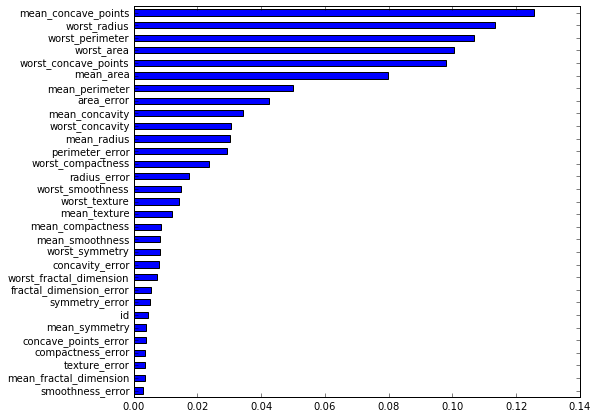

In [181]:
features_importance = pd.Series(rfr_mod.feature_importances_, index=X.columns.values)
features_importance.sort_values(inplace=True)
features_importance.plot(kind="barh", figsize=(8,7));